## Imports

In [10]:
import sys
from multiprocessing import Pool

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import cdist, pdist
from copy import deepcopy
import warnings
from numba import njit, prange
from arviz.labels import MapLabeller
from eryn.ensemble import EnsembleSampler
from eryn.utils import Update
from eryn.moves import (
    CombineMove,
    DistributionGenerateRJ,
    GaussianMove,
    MTDistGenMoveRJ,
    StretchMove,
    GroupStretchMove,
)
from eryn.prior import ProbDistContainer
from eryn.state import State
from eryn.utils import TransformContainer
from scipy.stats import invgamma, norm, uniform
from sklearn.model_selection import KFold, train_test_split

sys.path.append("../../TFM/rk-bfr")
seed = 42
rng = np.random.default_rng(seed)
np.random.seed(seed)

import utils.simulation_utils as simulation
from utils import plot_utils

%matplotlib inline
%load_ext autoreload
%load_ext watermark
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


## Dataset

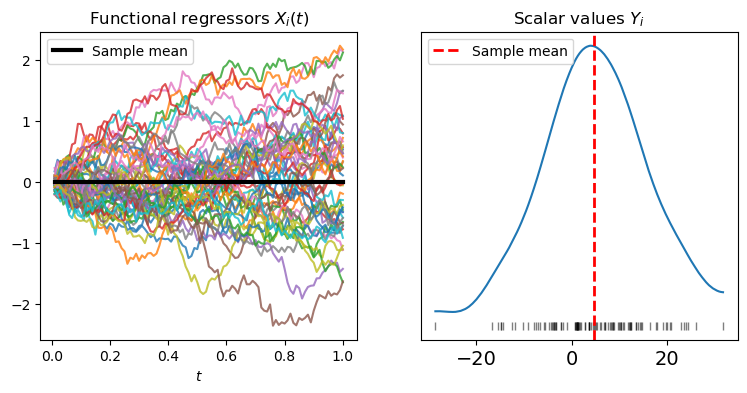

In [2]:
SYNTHETIC_DATA = True
MODEL_GEN = "RKHS"

# define true parameters
component_params = np.array(
    [
        [-5, 0.1],
        [5, 0.6],
        [10, 0.8],
    ]
)
alpha0 = 5
sigma2 = 0.5

# define dataset parameters
ngrid = 100
n_train, n_test = 100, 50
mean_vector = np.zeros(ngrid)
kernel_fn = simulation.brownian_kernel

# generate regressors and response
t = np.linspace(1.0 / ngrid, 1, ngrid)
x = simulation.gp(t, mean_vector, kernel_fn, n_train + n_test, rng=rng)
y = simulation.generate_rkhs_dataset(
    x, t, component_params.T[0], component_params.T[1], alpha0, sigma2, rng=rng
)
y_noiseless = simulation.generate_rkhs_dataset(
    x, t, component_params.T[0], component_params.T[1], alpha0, 0.0, rng=rng
)

# Train/test split and standardize
indices = np.arange(n_train + n_test)  # for future convenience
X, X_test, Y, Y_test, idx_train, idx_test = train_test_split(
    x, y, indices, train_size=n_train, random_state=seed
)
X, X_test = simulation.standardize_predictors(X, X_test, scale=False)
# Y, Y_test = simulation.standardize_response(Y, Y_test)

# Plot dataset
plot_utils.plot_dataset_regression(
    X,
    Y,
    n_samples=n_train // 2,
)

## Bayesian model

In [3]:
class LogSqrtTransform():
    @staticmethod
    @njit(cache=True, fastmath=True, parallel=True)
    def forward(x):
        return np.log(np.sqrt(x))
        
    @staticmethod
    @njit(cache=True, fastmath=True, parallel=True)
    def backward(y):
        return np.exp(y)**2

class LogTransform():
    @staticmethod
    @njit(cache=True, fastmath=True, parallel=True)
    def forward(x):
        return np.log(x)
        
    @staticmethod
    @njit(cache=True, fastmath=True, parallel=True)
    def backward(y):
        return np.exp(y)

class SqrtTransform():
    @staticmethod
    @njit(cache=True, fastmath=True, parallel=True)
    def forward(x):
        return np.sqrt(x)
        
    @staticmethod
    @njit(cache=True, fastmath=True, parallel=True)
    def backward(y):
        return y**2

TRANSFORM_SIGMA = False
RELABEL_STRATEGY = "auto"  # beta, tau or auto

### Prior

In [4]:
class jeffreys_prior:
    """Jeffrey's prior P(sigma2) ∝ 1/sigma2. It is equivalent to flat prior on log(sigma)"""
    def logpdf(self, x):
        """It receives an array (N,) of samples. It must check the bounds and return an array
        (N,) with -np.inf in positions of invalid values."""
        res = np.full_like(x, -np.inf)
        idx_valid = np.where(x > 0)  # identify samples where sigma2 > 0
        res[idx_valid] = -np.log(x[idx_valid])  # log P(sigma2) ∝ -log(sigma2)
        return res

class flat_prior:
    """Flat prior P(log(sigma)) ∝ 1"""
    def logpdf(self, x):
        return np.zeros_like(x)

def uniform_dist(a, b):
    """Wrapper around scipy.stats.uniform; similar to eryn.prior.uniform_dist, but without
    the error that it needs floating numbers as input to logpdf or else it fails."""
    return uniform(loc=a, scale=b - a)


class RKHSPriorSimple:
    """the prior on p (the number of components) is assumed to be uniform in [1, n_leaves_max]"""

    def __init__(self, t, X, Y_mean, transform_sigma=False):
        # Dataset information
        self.t = t
        self.X = x
        self.Y_mean = Y_mean

        # Indices in the coords array
        self.idx_beta = 0
        self.idx_tau = 1
        self.idx_alpha0 = 0
        self.idx_sigma2 = 1

        # Independent priors
        self.prior_beta = norm(0, 10)
        self.prior_tau = uniform_dist(t.min(), t.max())
        self.prior_sigma2 = flat_prior() if transform_sigma else jeffreys_prior()

        # Other information
        self.transform_sigma = transform_sigma

    def logpdf_components(self, coords, inds_components):
        """inds_components is a multi-index (3-uple of arrays) for coords["components"],
        which indicates the components for which to compute the logpdf."""
        # Get current values of theta
        beta = coords["components"][..., self.idx_beta]
        tau = coords["components"][..., self.idx_tau]

        # Compute logpdf for beta and tau
        lp_beta = self.prior_beta.logpdf(beta[inds_components])
        lp_tau = self.prior_tau.logpdf(tau[inds_components])

        return lp_beta + lp_tau

    def logpdf(self, coords, inds):
        # Get current values of theta
        beta = coords["components"][..., self.idx_beta]
        tau = coords["components"][..., self.idx_tau]
        alpha0 = coords["common"][..., self.idx_alpha0]
        sigma2 = coords["common"][..., self.idx_sigma2]  # log(sigma) if self.transform_sigma, else sigma2

        # Get conditional priors
        with warnings.catch_warnings():
             # Ignore warning when doing sqrt of a negative number; those positions are ignored later
            warnings.simplefilter("ignore", category=RuntimeWarning)
            sigma = LogTransform.backward(sigma2) if self.transform_sigma else SqrtTransform.forward(sigma2)
        prior_alpha0 = self._get_prior_alpha0(sigma)

        # Compute logpdf for beta and tau
        lp_beta = self.prior_beta.logpdf(beta)  # (ntemps, nwalkers, nleaves_max)
        lp_tau = self.prior_tau.logpdf(tau)  # (ntemps, nwalkers, nleaves_max)

        # Compute logpdf for alpha0 and sigma2
        lp_alpha0 = prior_alpha0.logpdf(alpha0)[..., 0]  # (ntemps, nwalkers)
        lp_sigma2 = self.prior_sigma2.logpdf(sigma2)[..., 0]  # (ntemps, nwalkers)

        # Turn off contribution of inactive leaves
        lp_beta[~inds["components"]] = 0.0
        lp_tau[~inds["components"]] = 0.0
        if not self.transform_sigma:
            lp_alpha0[np.isinf(lp_sigma2)] = 0.0  # Fix NaN in lp_alpha0

        return lp_beta.sum(axis=-1) + lp_tau.sum(axis=-1) + lp_alpha0 + lp_sigma2

    def rvs(self, size, coords=None, inds=None):
        """arguments coords are size are present for compatibility"""
        # Only generate samples for the RJ moves
        out = np.zeros((size,) + (2,))

        out[..., self.idx_beta] = self.prior_beta.rvs(size=size)
        out[..., self.idx_tau] = self.prior_tau.rvs(size=size)

        return out

    def _get_prior_alpha0(self, sigma):
        return norm(0, 10 * np.abs(self.Y_mean) * sigma)


priors_simple = {"all_models_together": RKHSPriorSimple(t, X, Y.mean(), transform_sigma=TRANSFORM_SIGMA)}

priors_initial = {
    "components": ProbDistContainer(
        {
            0: priors_simple[
                "all_models_together"
            ].prior_beta,  # beta  TODO: elegir según la escala de los datos (?)
            1: priors_simple["all_models_together"].prior_tau  # tau
        }
    ),
    "common": ProbDistContainer(
        {
            0: norm(
                0, 10 * np.abs(Y.mean())
            ),  # alpha0  TODO: elegir según la escala de los datos (?)
            1: priors_simple["all_models_together"].prior_sigma2,
        }
    ),
}

### Likelihood

In [5]:
class RKHSLikelihood:
    def __init__(self, t, X, y, transform_sigma=False):
        self.t = t
        self.X_T = np.ascontiguousarray(X.T)
        self.y = y
        self.n = X.shape[0]
        self.transform_sigma = transform_sigma

    # METHOD 1: Sequential computation for future parallelization with pool argument in Eryn
    def evaluate_sequential(self, theta):
        """Computes the log-likelihood log P(Y1,...,Y_n|theta, X_1, ..., X_n) for a single walker.

        - theta is a list [theta_components, theta_common] that represent the parameters for a single walker.
            * theta_components is an array (p, 2) of the parameters (b_j, t_j) for each component (leaf), where 1<=p<=p_max.
              In other words, on each call to this function the shape varies according to how many leaves are active.
            * theta_common is an array (1, 2) of the parameters alpha_0 and sigma^2, which are common for all models (leaves).
        - t is the discretized grid of shape (ngrid,)
        - X, y are the data, of shape (nfunc, ngrid) and (nfunc,) respectively.

        ========
        Return: the log-likelihood for the walker, i.e., log P(Y|theta, X).

        ========
        Note: Eryn already checks that the theta input values are valid (i.e. within the bounds of the prior).
        """
        theta_components, theta_common = theta
        beta = np.ascontiguousarray(theta_components[:, 0])
        tau = np.ascontiguousarray(theta_components[:, 1:2])
        alpha0 = theta_common[0][0]

        if self.transform_sigma:
            log_sigma = theta_common[0][1]
            sigma2 = LogSqrtTransform.backward(log_sigma)
        else:
            sigma2 = theta_common[0][1] 
            log_sigma = LogSqrtTransform.forward(sigma2)
            
        # Compute the indices of the grid corresponding to the parameter tau
        idx_tau = cdist(tau, self.t[:, None], 'cityblock').argmin(axis=1)  # == np.abs(self.t - tau).argmin(axis=1)

        diff = self.y - alpha0 - self.X_T[idx_tau].T @ beta
        ll = -self.n * log_sigma - 0.5 * (diff @ diff) / sigma2

        return ll

    # Method 2: Vectorized computation with parallel execution of inner loop
    def evaluate_vectorized(self, theta, groups):
        """Computes the log-likelihood log P(Y_1,...,Y_n|[Theta], X_1, ..., X_n) for all walkers and temps.

        - theta is a list [theta_components, theta_common] that represents the parameters for _all_ walkers (across
          all temperatures).
            * theta_components is an array (N, 2) of the parameters (b_j, t_j) for all walkers and temps. N is the total
              number of active parameters in the RJ branch, i.e., N=sum(inds["components"]). Informally, we can
              compute N as nwalkers*ntemps*(active leaves on each (nwalker, ntemp)). In these arrays we have no
              information about which walker the parameters belong to; we just know their values.
            * theta_common is an array (M, 2) of the parameters alpha_0 and sigma^2 for all walkers and temps. M is
              the total number of such parameters (which is fixed), i.e., M=nwalkers*ntemps. In general, N >= M.
        - groups is a list [groups_components, groups_common] that represents the correspondence between parameters
          in the flattened array theta_* and the specific walker they belong to. Each group_* array contains integers,
          and each position within them represents the walker #id of the corresponding parameter in the same position
          on the theta_* array of parameters. The range of possible values is {1, 2, ..., M}. Eryn internally converts
          the inds array to groups information (eryn.utils.groups_from_inds), so that only active parameters are
          considered for the likelihood computation.
            * groups_components is an array (N,).
            * groups_common is an array (M,), and since the corresponding parameters are fixed and nleaves_min=1 in this
              branch, groups_common=np.arange(M). This parameter can be safely ignored.
        - t is the grid of shape (ngrid,)
        - X, y are the data, of shape (nfunc, ngrid) and (nfunc,) respectively.

        ========
        Example: suppose ntemps=2, nwalkers=2, and on each of the 4 total walkers we have 1, 2, 3 and 2 components active,
                 respectively. Then, N=1+2+3+2=8, while M=2*2=4. We would have groups_components = [0,1,1,2,2,2,3,3]
                 and groups_common = [0,1,2,3]. To compute the likelihood for walker i, we have to collect all theta_components
                 corresponding to this walker #id (whose indices are given by np.where(groups_components == i)), as well as
                 the corresponding alpha_0 and sigma^2 (theta_common[i]), and perform the computation per the model.

        ========
        Return: array (M,) in which each position is the log-likelihood for a specific walker, i.e.,
                log P(Y|Theta_i, X) (i=1,...,M).

        ========
        Note: Eryn already checks that the theta input values are valid (i.e. within the bounds of the prior).
        """
        theta_components, theta_common = theta
        groups_components, _ = groups

        beta = np.ascontiguousarray(theta_components[:, 0])
        tau = np.ascontiguousarray(theta_components[:, 1:2])
        alpha0 = np.ascontiguousarray(theta_common[:, 0])

        if self.transform_sigma:
            log_sigma = np.ascontiguousarray(theta_common[:, 1])
            sigma2 = LogSqrtTransform.backward(log_sigma)
        else:
            sigma2 = np.ascontiguousarray(theta_common[:, 1])
            log_sigma = LogSqrtTransform.forward(sigma2)

        idx_tau = cdist(tau, self.t[:, None], 'cityblock').argmin(axis=1)  # == np.abs(self.t - tau).argmin(axis=1)
        unique_indices = np.unique(groups_components)

        ll = self._compute_ll_parallel(
            groups_components,
            unique_indices,
            beta,
            idx_tau,
            alpha0,
            sigma2,
            log_sigma,
            self.X_T,
            self.y,
            self.n,
        )

        return ll

    # Actual parallel computation of log_likelihood for all groups
    @staticmethod
    @njit(
        parallel=True,
        fastmath=True,
        cache=True,
    )
    def _compute_ll_parallel(
        groups_components: np.ndarray,
        unique_indices: np.ndarray,
        beta: np.ndarray,
        idx_tau: np.ndarray,
        alpha0: np.ndarray,
        sigma2: np.ndarray,
        log_sigma: np.ndarray,
        X_T: np.ndarray,
        y: np.ndarray,
        n: np.ndarray,
    ) -> np.ndarray:
        # Preallocate memory
        ll = np.empty_like(unique_indices, dtype=np.float64)
        X_tau_masked = np.empty_like(X_T[0])
        beta_masked = np.empty_like(beta[0])
        diff = np.empty_like(y)
        n_unique = len(unique_indices)

        for i in prange(n_unique):
            idx = unique_indices[i]
            mask = np.where(groups_components == idx)
            X_tau_masked = np.ascontiguousarray(X_T[idx_tau[mask]])
            beta_masked = beta[mask]
            alpha0_masked = alpha0[idx]
            sigma2_masked = sigma2[idx]
            log_sigma_masked = log_sigma[idx]
            
            diff = y - alpha0_masked - np.dot(X_tau_masked.T, beta_masked)
            ll[i] = -n * log_sigma_masked - 0.5 * np.dot(diff, diff) / sigma2_masked

        return ll

## Sampler

### Moves

In [23]:
class GroupMoveRKHS(GroupStretchMove):
    def __init__(self, dist_measure="norm", **kwargs):
        super(GroupMoveRKHS, self).__init__(**kwargs)
        if dist_measure == "norm":
            self.idx_reference = None
        elif dist_measure == "beta":
            self.idx_reference = 0
        elif dist_measure == "tau":
            self.idx_reference = 1
        else:
            raise ValueError(f"Incorrect value {dist_measure} for dist_measure")

    def setup_friends(self, branches):
        self.coords_friends = branches["components"].coords[branches["components"].inds]
        if self.idx_reference is None:
            self.reference_values = self.coords_friends
        else:
            self.reference_values = self.coords_friends[:, self.idx_reference]

    @staticmethod
    @njit(cache=True, fastmath=True, parallel=True)
    def _random_nearest_friends(dist, nfriends, inds_choice):
        n_idx = len(dist)
        keep = np.empty(n_idx, dtype=np.int64)

        for i in prange(n_idx):
            dist_row = dist[i]
            partitioned_indices = np.argpartition(dist_row, nfriends)[:nfriends]
            sorted_partitioned_row = np.argsort(dist_row[partitioned_indices])
            sorted_partitioned_indices = partitioned_indices[sorted_partitioned_row]
            idx = inds_choice[i]
            keep[i] = sorted_partitioned_indices[idx]
        return keep

    def find_friends(self, name, s, s_inds):
        """For each parameter, assign a random friend from the nfriends closest ones
        in terms of distance."""
        friends = np.zeros_like(s)
        coords_here = s[s_inds]
        n_idx = len(coords_here)

        if self.idx_reference is None:
            dist = cdist(coords_here, self.coords_friends, "sqeuclidean")
        else:
            dist = cdist(
                coords_here[:, self.idx_reference, None],
                self.coords_friends[:, self.idx_reference, None],
                "sqeuclidean",
            )

        inds_choice = np.random.randint(0, self.nfriends, size=n_idx)
        keep = self._random_nearest_friends(dist, self.nfriends, inds_choice)
        friends[s_inds] = self.coords_friends[keep]

        return friends


class RJMoveRKHS(DistributionGenerateRJ):
    def __init__(self, priors, zellner=False, *args, **kwargs):
        self.priors = priors
        self.zellner = zellner
        generate_dist = {  # unused; only for compatibility
            "components": ProbDistContainer({(0, 1): priors})
        }
        super(RJMoveRKHS, self).__init__(generate_dist, *args, **kwargs)

    @staticmethod
    @njit(cache=True, fastmath=True)
    def get_model_change_proposal(
        inds, change, nleaves_min, nleaves_max, nleaves, seed
    ):
        """Helper function for changing the model count by 1.

        This helper function works with nested models where you want to add or remove
        one leaf at a time.

        Args:
            inds (np.ndarray): ``inds`` values for this specific branch with shape
                ``(ntemps, nwalkers, nleaves_max)``.
            random (object): Current random state of the sampler.
            nleaves_min (int): Minimum allowable leaf count for this branch.
            nleaves_max (int): Maximum allowable leaf count for this branch.

        Returns:
            inds_birth_array (np.ndarray), inds_death_array (np.ndarray):
                    The indexing information is a 2D array with shape ``(number changing, 3)``.
                    The length 3 is the index into each of the ``(ntemps, nwalkers, nleaves_max)``.

        """
        np.random.seed(seed)
        ntemps, nwalkers = inds.shape[:2]

        # fix edge cases
        change = (
            change * ((nleaves != nleaves_min) & (nleaves != nleaves_max))
            + (+1) * (nleaves == nleaves_min)
            + (-1) * (nleaves == nleaves_max)
        )

        # setup storage for this information
        num_increases = np.sum(change == +1)
        num_decreases = np.sum(change == -1)
        inds_birth_array = np.zeros((num_increases, 3), dtype=np.int64)
        inds_death_array = np.zeros((num_decreases, 3), dtype=np.int64)

        increase_i = 0
        decrease_i = 0
        for t in range(ntemps):
            for w in range(nwalkers):
                # check if add or remove
                change_tw = change[t][w]
                # inds array from specific walker
                inds_tw = inds[t][w]

                # adding
                if change_tw == +1:
                    # find where leaves are not currently used
                    inds_false = np.where(inds_tw == False)[0]
                    # decide which spot to add
                    ind_change = np.random.choice(inds_false)
                    # put in the indexes into inds arrays
                    inds_birth_array[increase_i] = np.array(
                        [t, w, ind_change], dtype=np.int64
                    )
                    # count increases
                    increase_i += 1

                # removing
                elif change_tw == -1:
                    # find which leaves are used
                    inds_true = np.where(inds_tw == True)[0]
                    # choose which to remove
                    ind_change = np.random.choice(inds_true)
                    # add indexes into inds
                    inds_death_array[decrease_i] = np.array(
                        [t, w, ind_change], dtype=np.int64
                    )
                    decrease_i += 1
                    # do not care currently about what we do with discarded coords, they just sit in the state

        return inds_birth_array, inds_death_array

    def get_proposal(
        self, all_coords, all_inds, nleaves_min_all, nleaves_max_all, random, **kwargs
    ):
        """Make a proposal

        Args:
            all_coords (dict): Keys are ``branch_names``. Values are
                np.ndarray[ntemps, nwalkers, nleaves_max, ndim]. These are the curent
                coordinates for all the walkers.
            all_inds (dict): Keys are ``branch_names``. Values are
                np.ndarray[ntemps, nwalkers, nleaves_max]. These are the boolean
                arrays marking which leaves are currently used within each walker.
            nleaves_min_all (dict): Minimum values of leaf ount for each model. Must have same order as ``all_cords``.
            nleaves_max_all (dict): Maximum values of leaf ount for each model. Must have same order as ``all_cords``.
            random (object): Current random state of the sampler.
            **kwargs (ignored): For modularity.

        Returns:
            tuple: Tuple containing proposal information.
                First entry is the new coordinates as a dictionary with keys
                as ``branch_names`` and values as
                ``double `` np.ndarray[ntemps, nwalkers, nleaves_max, ndim] containing
                proposed coordinates. Second entry is the new ``inds`` array with
                boolean values flipped for added or removed sources. Third entry
                is the factors associated with the
                proposal necessary for detailed balance. This is effectively
                any term in the detailed balance fraction. +log of factors if
                in the numerator. -log of factors if in the denominator.

        """
        # get input information for the components branch
        coords_components = all_coords["components"]
        inds_components = all_inds["components"]
        nleaves_min_components = nleaves_min_all["components"]
        nleaves_max_components = nleaves_max_all["components"]

        # put in base information
        ntemps, nwalkers = coords_components.shape[:2]
        q = deepcopy(all_coords)
        new_inds = deepcopy(all_inds)
        factors = np.zeros((ntemps, nwalkers))

        # skip if no movement allowed
        if nleaves_min_components == nleaves_max_components:
            return q, new_inds, factors

        # choose whether to add or remove
        nleaves = inds_components.sum(axis=-1)
        if self.fix_change is None:
            change = random.choice([-1, +1], size=nleaves.shape)
        else:
            change = np.full(nleaves.shape, self.fix_change)

        # get the inds adjustment information
        # For birth and deaths, each row is the index of (ntemp, nwalker, nleaves_max) that changes
        seed = random.get_state()[1][0]
        inds_birth_array, inds_death_array = self.get_model_change_proposal(
            inds_components,
            change,
            nleaves_min_components,
            nleaves_max_components,
            nleaves,
            seed,
        )

        # adjust deaths from True -> False
        inds_death = tuple(inds_death_array.T)  # multi-index for numpy arrays
        new_inds["components"][inds_death] = False

        # factor is +log q()
        factors[inds_death[:2]] += +1 * self.priors.logpdf_components(q, inds_death)

        # adjust births from False -> True
        inds_birth = tuple(inds_birth_array.T)  # multi-index for numpy arrays
        new_inds["components"][inds_birth] = True

        # add coordinates for new leaves
        num_inds_change = len(inds_birth[0])
        if self.zellner:
            q["components"][inds_birth] = self.priors.rvs(
                num_inds_change, coords=all_coords, inds=all_inds
            )
        else:
            q["components"][inds_birth] = self.priors.rvs(num_inds_change)

        # factor is -log q()
        factors[inds_birth[:2]] += -1 * self.priors.logpdf_components(q, inds_birth)

        return q, new_inds, factors


class AdjustStretchScaleCombineMove(Update):
    def __init__(
        self,
        idx_moves=None,
        target_acceptance=0.22,
        supression_factor=0.1,
        max_factor=0.5,
        min_a=1.1,
        verbose=False,
    ):
        if idx_moves is None:
            self.idx_moves = [0]
        else:
            self.idx_moves = idx_moves

        self.target_acceptance = target_acceptance
        self.supression_factor = supression_factor
        self.max_factor = max_factor
        self.min_a = min_a
        self.verbose = verbose

        self.time = 0
        self.previously_accepted = {}

    def __call__(self, iter, last_sample, sampler):
        for idx in self.idx_moves:
            move = sampler.moves[0].moves[idx]
            change = 1.0
            mean_af = 0.0

            if self.time > 0:
                # cold chain -> T=0
                mean_af = np.mean(
                    (move.accepted[0] - self.previously_accepted[idx])
                    / (sampler.backend.iteration - self.previous_iter)
                )

                if mean_af > self.target_acceptance:
                    factor = self.supression_factor * (mean_af / self.target_acceptance)
                    if factor > self.max_factor:
                        factor = self.max_factor
                    change = 1 + factor

                else:
                    factor = self.supression_factor * (self.target_acceptance / mean_af)
                    if factor > self.max_factor:
                        factor = self.max_factor
                    change = 1 - factor

                # F
                if move.a * change > self.min_a:
                    move.a *= change
                else:
                    move.a = self.min_a

            self.previously_accepted[idx] = move.accepted[0].copy()

            if self.verbose:
                print(
                    f"[{move.__class__.__name__}] iter={sampler.backend.iteration} a={move.a:.2f}"
                )

        self.time += 1
        self.previous_iter = sampler.backend.iteration

### Initial values

In [7]:
# set up chain parameters
branch_names = ["components", "common"]
nleaves_max = {"components": 5, "common": 1}
nleaves_min = {"components": 1, "common": 1}
ndims = {"components": 2, "common": 2}
nwalkers = 32
ntemps = 5

# set coordinates for the leaf values in both branches
coords = {
    branch: np.zeros((ntemps, nwalkers, nleaf, ndim))
    for nleaf, ndim, branch in zip(nleaves_max.values(), ndims.values(), branch_names)
}

# sample initial values for components (b,t) and alpha0 from prior
coords["components"] = priors_initial["components"].rvs(
    size=(ntemps, nwalkers, nleaves_max["components"])
)
coords["common"][:, :, 0, 0] = (
    priors_initial["common"].priors_in[0].rvs(size=(ntemps, nwalkers))
)  # no need to establish ordering on b or tau

# sample initial values for sigma2 from inverse-gamma distribution
sigma2_param = 2  # TODO: change?
init_sigma2 = invgamma(sigma2_param).rvs(size=(ntemps, nwalkers))
coords["common"][:, :, 0, 1] = LogSqrtTransform.forward(init_sigma2) if TRANSFORM_SIGMA else init_sigma2

# set indices for used/unused leaves of components (boolean 0/1)
# we need to ensure that not all components are zero on any walker,
# because nleaves_min = 1
inds = {}
inds["components"] = np.random.randint(
    2, size=(ntemps, nwalkers, nleaves_max["components"]), dtype=bool
)
idx = np.where(np.sum(inds["components"], axis=-1) == 0)
inds["components"][*idx, 0] = True

# set indices for the single leaf of [alpha0,sigma2] (always used because nleaves_min=nleaves_max=1)
inds["common"] = np.ones((ntemps, nwalkers, nleaves_max["common"]), dtype=bool)

## Experiments

In [24]:
# number of steps
nsteps = 100
thin_by = 1
burn = 500

# number of cores
njobs = 4
vectorize = True

# moves
move_stretch = StretchMove(gibbs_sampling_setup="common", a=2)

factor = 0.00001
cov = {"common": np.diag(np.ones(ndims["common"])) * 0.00001}
move_gaussian = GaussianMove(cov, gibbs_sampling_setup="common")

# Sample all parameters leaf by leaf in the components branch (currently unused)
gibbs_sampling_setup_group = [
    (
        "components",
        np.zeros((nleaves_max["components"], ndims["components"]), dtype=bool),
    )
    for _ in range(nleaves_max["components"])
]
for i in range(nleaves_max["components"]):
    gibbs_sampling_setup_group[i][-1][i] = True

move_group = GroupMoveRKHS(
    dist_measure="beta",
    nfriends=nwalkers,
    n_iter_update=100,
    gibbs_sampling_setup="components",  # gibbs_sampling_setup_group
    a=2,
)

# rj moves
num_try = 10
rjmoveMT = MTDistGenMoveRJ(  # multiple-try distgen from prior
    {"components": priors_initial["components"]},
    # {"components": ProbDistContainer({(0,1): priors_alt["all_models_together"]})},
    nleaves_max={
        branch: value for branch, value in zip(branch_names, nleaves_max.values())
    },
    nleaves_min={
        branch: value for branch, value in zip(branch_names, nleaves_min.values())
    },
    gibbs_sampling_setup="components",  # only perform RJ on the components
    num_try=num_try,
    rj=True,
)

rjmoveRKHSSimple = RJMoveRKHS(
    priors_simple["all_models_together"],
    nleaves_max={
        branch: value for branch, value in zip(branch_names, nleaves_max.values())
    },
    nleaves_min={
        branch: value for branch, value in zip(branch_names, nleaves_min.values())
    },
    rj=True,
    gibbs_sampling_setup="components",  # Do not specify this if using Zellner prior on beta
)

# log_likelihood object
ll = RKHSLikelihood(t, X, Y, transform_sigma=TRANSFORM_SIGMA)

# update function
update_fn_group = AdjustStretchScaleCombineMove(
    idx_moves=[0, 1], target_acceptance=0.3, max_factor=0.1, supression_factor=0.1
)
update_iters = 10

# re-set random seed for reproducible sampling
np.random.seed(seed)

# sample
with Pool(njobs) as pool:
    ensemble = EnsembleSampler(
        nwalkers,
        ndims,
        ll.evaluate_vectorized if vectorize else ll.evaluate_sequential,
        priors_simple,
        pool=pool,
        vectorize=vectorize,
        provide_groups=vectorize,
        tempering_kwargs=dict(ntemps=ntemps),
        nbranches=len(branch_names),
        branch_names=branch_names,
        nleaves_max=nleaves_max,
        nleaves_min=nleaves_min,
        moves=CombineMove([move_group, move_stretch]),
        rj_moves=rjmoveRKHSSimple,
        update_fn=update_fn_group,
        update_iterations=update_iters,
    )

    # setup starting state
    state = State(coords, inds=inds)

    # run the sampler
    print("Sampling posterior distribution...")
    last_sample = ensemble.run_mcmc(
        state, nsteps, burn=burn, progress=True, thin_by=thin_by
    )


# Print sampling information
print(f"* Last sample (transform_sigma = {TRANSFORM_SIGMA}):")
print(last_sample.branches["components"].inds[0, 0, :])
print(last_sample.branches_coords["components"][0, 0, :])
print(last_sample.branches_coords["common"][0, 0, :])
print("\n* Acceptance % (T=0)")
print(f"[{ensemble.moves[0].moves[0].__class__.__name__}]", 100 * ensemble.moves[0].acceptance_fraction_separate[0][0])
print(f"[{ensemble.moves[0].moves[1].__class__.__name__}]", 100 * ensemble.moves[0].acceptance_fraction_separate[1][0])
print(f"[{ensemble.rj_moves[0].__class__.__name__}]", 100 * ensemble.rj_acceptance_fraction[0])
print("\n* Last values of a:")
print(f"[GroupMoveRKHS] a={ensemble.moves[0].moves[0].a:.2f}")
print(f"[StretchMove] a={ensemble.moves[0].moves[1].a:.2f}")

Sampling posterior distribution...


100%|██████████| 100/100 [00:00<00:00, 105.80it/s]

* Last sample (transform_sigma = False):
[ True False  True  True  True]
[[-3.47701836  0.09783605]
 [ 0.15028498  1.01960323]
 [-1.22497978  0.80188989]
 [11.75155638  0.80253692]
 [ 4.0283964   0.60291419]]
[[4.47725118 0.61387673]]

* Acceptance % (T=0)
[GroupMoveRKHS] [7.         7.16666667 4.66666667 4.33333333 4.66666667 8.33333333
 8.66666667 6.66666667 8.16666667 7.83333333 9.66666667 6.66666667
 9.33333333 4.16666667 5.         4.5        6.         5.66666667
 5.66666667 4.33333333 5.         5.5        4.66666667 4.83333333
 7.83333333 4.5        4.83333333 6.83333333 5.66666667 5.
 5.16666667 7.5       ]
[StretchMove] [59.83333333 60.83333333 63.66666667 62.16666667 60.33333333 63.5
 45.5        52.83333333 60.33333333 57.33333333 54.16666667 55.83333333
 57.         63.83333333 59.16666667 54.66666667 63.66666667 64.66666667
 62.33333333 62.33333333 53.5        58.         62.5        60.33333333
 54.66666667 61.66666667 58.66666667 60.16666667 56.5        36.83333333
 61.

## Analysis

In [25]:
def get_full_chain_at_T(sampler, T=0, discard=0, transform_sigma=False, relabel_strategy="auto"):
    # Get chain from sampler
    chain = sampler.get_chain(discard=discard).copy()
    
    if transform_sigma:
        chain["common"][:, T, ..., 1] = LogSqrtTransform.backward(
            chain["common"][:, T, ..., 1]
        )

    chain_components = chain["components"][:, T, ...]
    chain_common = chain["common"][:, T, ...].squeeze()

    if relabel_strategy == "auto":  # Relabeling algorithm of Simola et al. (2021)
        beta_flat = np.sort(
            chain_components[..., 0].reshape(-1, sampler.nleaves_max["components"]), 
            axis=-1
        )
        tau_flat = np.sort(
            chain_components[..., 1].reshape(-1, sampler.nleaves_max["components"]), 
            axis=-1
        )
        
        # Rescale parameters to common units
        beta_scale = np.nanmean(
            norm.cdf(beta_flat, loc=np.nanmean(beta_flat), scale=np.nanstd(beta_flat)), 
            axis=0
        )
        tau_scale = np.nanmean(
            norm.cdf(tau_flat, loc=np.nanmean(tau_flat), scale=np.nanstd(tau_flat)), 
            axis=0
        )
        
        # Look for the maximum pairwise distance
        pdist_beta_max = np.max(pdist(beta_scale.reshape(-1, 1)))
        pdist_tau_max = np.max(pdist(tau_scale.reshape(-1, 1)))
        idx_order = 0 if pdist_beta_max > pdist_tau_max else 1
        
    else:  # Manual relabeling
        idx_order = 0 if relabel_strategy == "beta" else 1
    
    # Order the last dimension based on b or t, maintaining shape and the correspondence b_i <--> t_i
    sorted_indices = np.argsort(chain_components[..., idx_order], axis=-1) 
    chain_components = np.take_along_axis(chain_components, sorted_indices[..., None], axis=-2)

    # Get indices and fix the sorting
    inds = sampler.get_inds(discard=discard).copy()
    inds_components = np.take_along_axis(inds["components"][:, T, ...], sorted_indices, axis=-1)
    inds_common = inds["common"][:, T, ...]
    
    return chain_components, chain_common, inds_components, inds_common, idx_order


def get_flat_chain_components(coords, ndim):
    """Simple utility function to extract the flat chains for all the parameters"""
    coords_T_0 = coords[..., 0].flatten()
    coords_T_1 = coords[..., 1].flatten()
    valid_idx = ~np.isnan(coords_T_0)
    samples_flat = np.zeros((np.sum(valid_idx), ndim))
    samples_flat[:, 0] = coords_T_0[valid_idx]
    samples_flat[:, 1] = coords_T_1[valid_idx]

    return samples_flat


def plot_mode(samples, ax):
    arr, density = az.kde(samples)
    idx_mode = np.argmax(density)
    mode = arr[idx_mode]
    ax.text(
        mode,
        ax.get_ylim()[1] * 0.8,
        f"mode={mode:.2f}",
        horizontalalignment="center",
        fontsize=8,
    )
    ax.scatter(mode, density[idx_mode], color="red", s=10)


def plot_reference_values(
    values,
    ax,
    vertical=True,
    label="Train value",
    color="blue",
    legend=True,
    alpha=0.5,
    legend_kwargs={},
):
    handles = []
    values = np.atleast_1d(values)
    for i, value in enumerate(values):
        if vertical:
            h = ax.axvline(
                x=value,
                color=color,
                linestyle="--",
                alpha=alpha,
                label=label,
            )
        else:
            h = ax.axhline(y=value, color=color, linestyle="--", alpha=alpha, label=label)
        if i == 0:
            handles += [h]

    if legend:
        ax.legend(handles=handles, **legend_kwargs)

    return handles



def plot_trace(
    chain,
    var_name="x",
    true_value=None,
    train_value=None,
    mode=False,
    color="blue",
    az_kwargs={},
):
    # Get chain (nwalkers, nsamples)
    chain = np.atleast_2d(chain)
    chain = chain.swapaxes(0, 1)  # for compatibility with arviz

    # Plot marginal posterior and trace
    ax = az.plot_trace(
        chain,
        combined=True,
        compact=False,
        chain_prop={"linestyle": ("solid", "dotted", "dashed", "dashdot")},
        labeller=MapLabeller({"x": var_name}),
        plot_kwargs={"color": color},
        trace_kwargs={"color": color, "alpha": 0.2},
        fill_kwargs={"alpha": 0.2},
        **az_kwargs,
    )
    ax[0,0].grid(alpha=0.3, linestyle="--")

    # Plot reference values
    handles = []
    if true_value is not None:
        true_value = np.atleast_1d(true_value)
        handles += plot_reference_values(
            true_value, ax[0, 0], label=f"True value", legend=False, color="k"
        )
        plot_reference_values(
            true_value, ax[0, 1], vertical=False, legend=False, color="k"
        )

    if train_value is not None:
        train_value = np.atleast_1d(train_value)
        handles += plot_reference_values(
            train_value, ax[0, 0], label=f"Train value", legend=False, color=color
        )
        plot_reference_values(
            train_value, ax[0, 1], vertical=False, legend=False, color=color, alpha=0.75
        )

    if mode:
        plot_mode(chain, ax[0, 0])

    if true_value is not None or train_value is not None:
        ax[0, 0].legend(handles=handles, fontsize=9)


# 1. Get full chain, with shape (nsteps, nwalkers, nleaves_max, ndim)
full_chain_components, full_chain_common, inds_components_post, inds_common_post, idx_order = get_full_chain_at_T(
    ensemble, T=0, transform_sigma=TRANSFORM_SIGMA, relabel_strategy=RELABEL_STRATEGY
)

# 2. Get flat chain, with shape (N, ndim), where N is the number of valid samples across all steps, walkers and leaves
flat_chain_components = get_flat_chain_components(
    full_chain_components, ndims["components"]
)
flat_chain_common = full_chain_common.reshape(-1, 2)

COLORS = ["darkgreen", "blue", "orange", "purple"]
VARS = ["b", "t", "alpha0", "sigma2"]

print(f"Chain ordered by {'beta' if idx_order == 0 else 'tau'}")

Chain ordered by beta


### Flat posterior distribution (for all p)

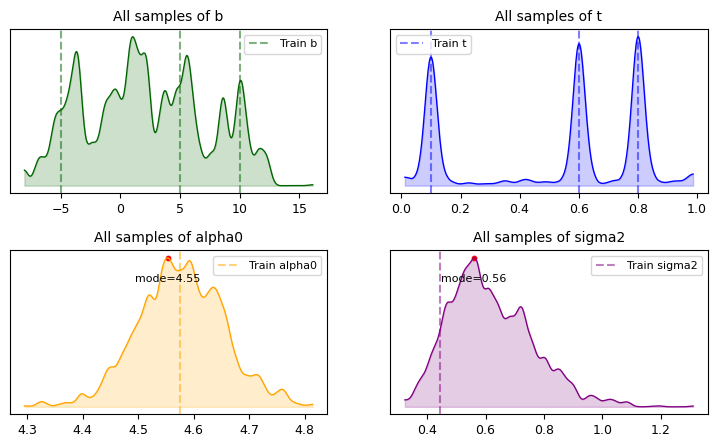

In [26]:
fig, axs = plt.subplots(2, 2, figsize=(9, 5))
plt.subplots_adjust(hspace=0.35)

samples_vars = [flat_chain_components[:, 0], flat_chain_components[:, 1], flat_chain_common[:, 0], flat_chain_common[:, 1]]
train_values = [component_params[:, 0], component_params[:, 1], Y.mean(), np.var(y[idx_train] - y_noiseless[idx_train])]

for i, (var, samples, ref_val, color) in enumerate(zip(VARS, samples_vars, train_values, COLORS)):
    ax = axs[i//2, i%2]
    # Set title and ticks
    ax.set_title(f"All samples of {var}", fontsize=10)
    ax.set_yticks([])  # Hide y-axis ticks
    ax.set_yticklabels([])  # Hide y-axis labels
    # Plot dist and reference values
    az.plot_dist(samples, ax=ax, color=color, fill_kwargs={"alpha": 0.2}, textsize=9)
    if SYNTHETIC_DATA and MODEL_GEN == "RKHS":
        plot_reference_values(ref_val, ax, label=f"Train {var}", color=color, legend_kwargs={"fontsize": 8})
    # Compute and plot mode for alpha0 and sigma2
    if i//2 > 0:
        plot_mode(samples, ax)

### Trace plot for individual components (for all p)

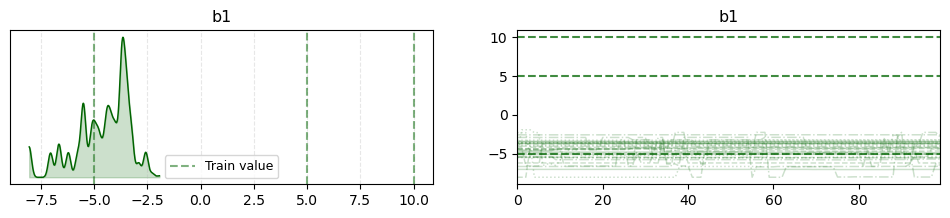

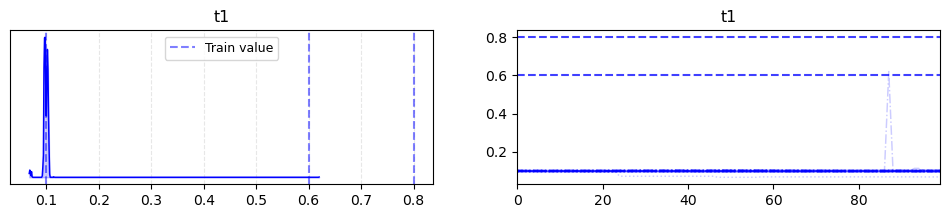

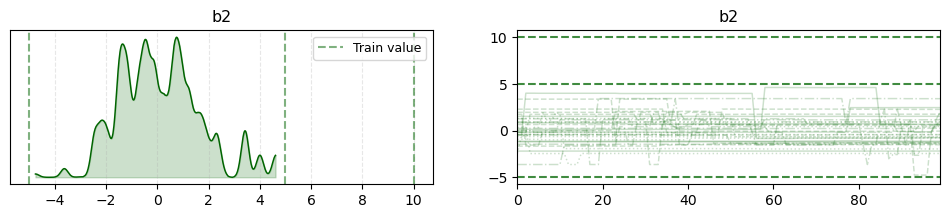

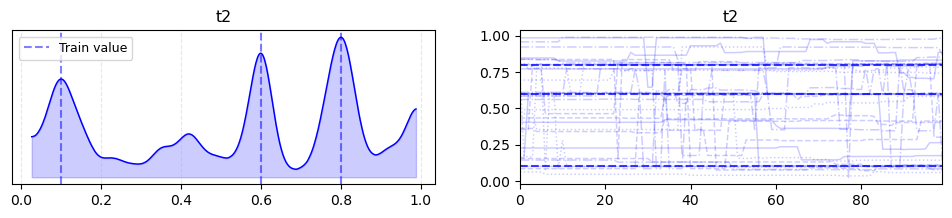

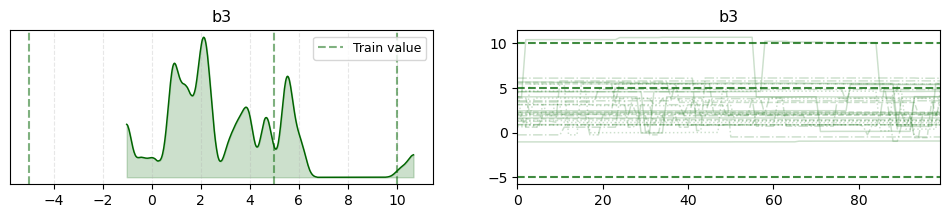

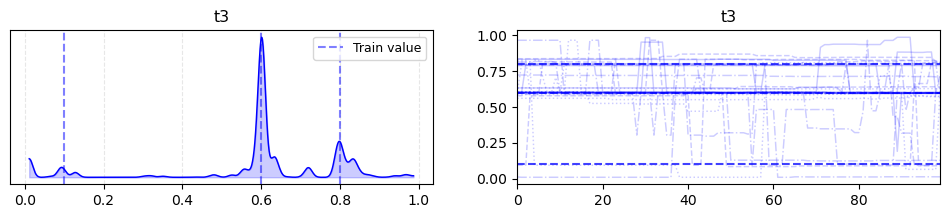

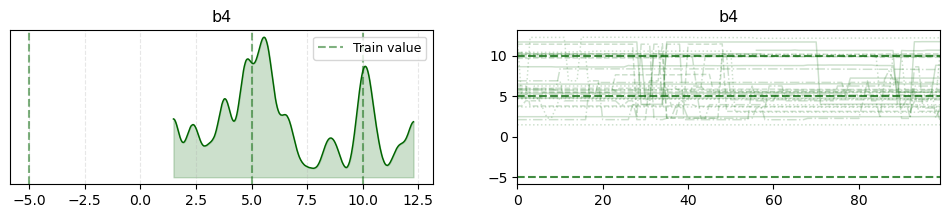

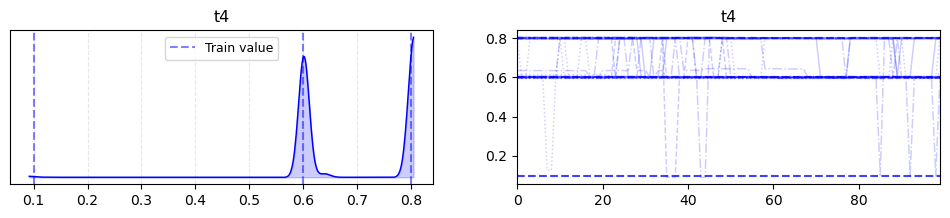

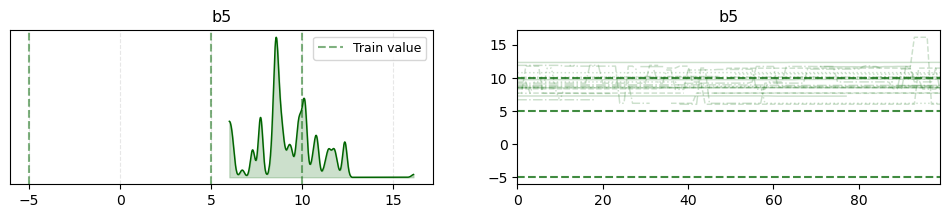

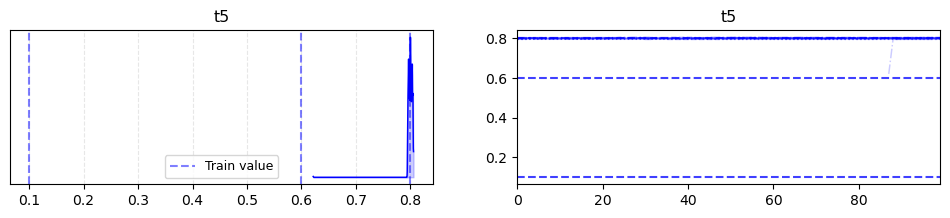

In [27]:
for component_id in range(nleaves_max["components"]):
    plot_trace(
        full_chain_components[..., component_id, 0],
        f"b{component_id + 1}",
        None,
        component_params[:, 0] if SYNTHETIC_DATA and MODEL_GEN == "RKHS" else None,
        color=COLORS[0],
    )
    plot_trace(
        full_chain_components[..., component_id, 1],
        f"t{component_id + 1}",
        None,
        component_params[:, 1] if SYNTHETIC_DATA and MODEL_GEN == "RKHS" else None,
        color=COLORS[1],
    )

### Trace plot for $\alpha_0$ and $\sigma^2$ (for all p)

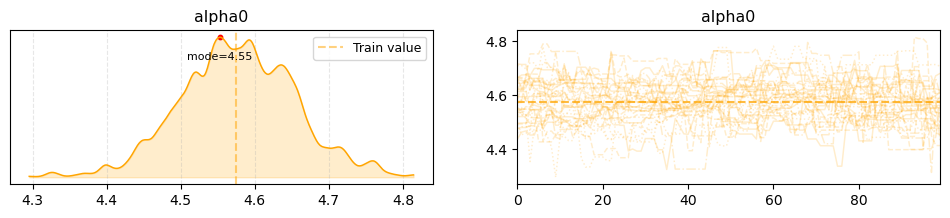

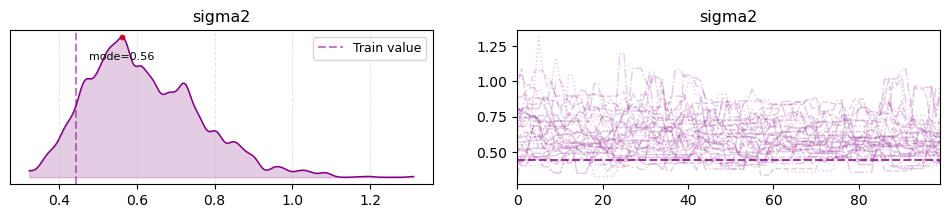

In [28]:
plot_trace(
    full_chain_common[..., 0],
    "alpha0",
    None,
    Y.mean() 
      if SYNTHETIC_DATA and MODEL_GEN == "RKHS" else None,
    mode=True,
    color=COLORS[2],
)
plot_trace(
    full_chain_common[..., 1],
    "sigma2",
    None,
    np.var(y[idx_train] - y_noiseless[idx_train]) 
      if SYNTHETIC_DATA and MODEL_GEN == "RKHS" else None,
    mode=True,
    color=COLORS[3],
)

### Posterior distribution of the number of components (p)

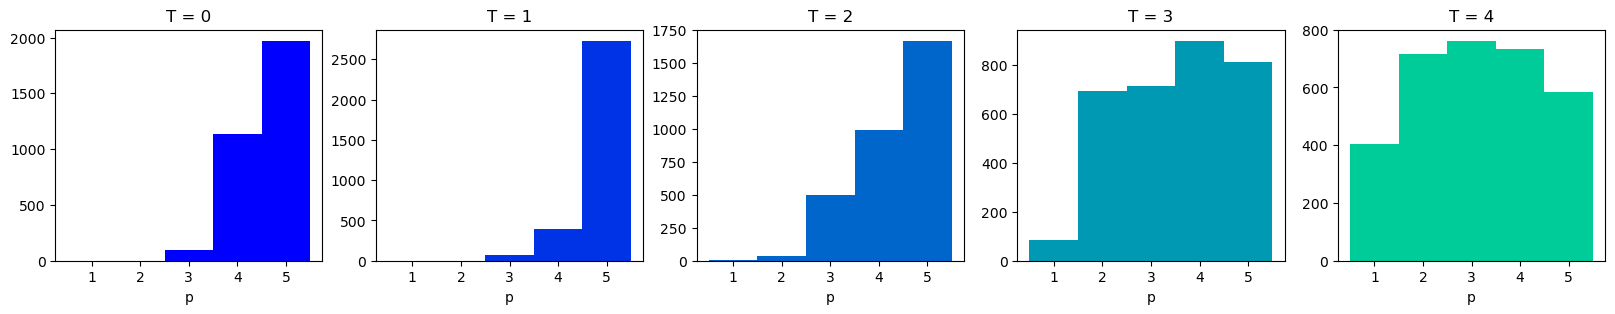

In [15]:
nleaves = ensemble.get_nleaves()["components"]
bins = np.arange(1, nleaves_max["components"] + 2) - 0.5
colors = plt.get_cmap("winter")

fig, ax = plt.subplots(1, ntemps, figsize=(4 * ntemps, 3))
for temp, ax_t in enumerate(ax):
    color = colors(temp / ntemps)
    ax_t.set_title("T = " + str(temp))
    ax_t.set_xlabel("p")
    ax_t.hist(nleaves[:, temp].flatten(), bins=bins, color=color)

In [16]:
%watermark -n -u -v -iv -w

Last updated: Tue Mar 19 2024

Python implementation: CPython
Python version       : 3.11.7
IPython version      : 8.19.0

matplotlib: 3.8.2
sys       : 3.11.7 | packaged by conda-forge | (main, Dec 23 2023, 14:43:09) [GCC 12.3.0]
arviz     : 0.17.0
numpy     : 1.23.5

Watermark: 2.4.3

